## Importing The libraries

In [1]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

## Loading The Datasets

In [2]:
claims = pd.read_csv("claims_data.csv")
food_listings = pd.read_csv("food_listings_data.csv")
providers = pd.read_csv("providers_data.csv")
receivers = pd.read_csv("receivers_data.csv")

print(len(claims))
print(len(food_listings))
print(len(providers))
print(len(receivers))

1000
1000
1000
1000


In [3]:
print("receivers", receivers.columns.to_list())

receivers ['Receiver_ID', 'Name', 'Type', 'City', 'Contact']


In [4]:
print("claims", claims.columns.to_list())

claims ['Claim_ID', 'Food_ID', 'Receiver_ID', 'Status', 'Timestamp']


In [5]:
print("providers", providers.columns.to_list())

providers ['Provider_ID', 'Name', 'Type', 'Address', 'City', 'Contact']


In [6]:
print("food_listings", food_listings.columns.to_list())

food_listings ['Food_ID', 'Food_Name', 'Quantity', 'Expiry_Date', 'Provider_ID', 'Provider_Type', 'Location', 'Food_Type', 'Meal_Type']


## Creating & Connecting to the Database

In [7]:
import mysql.connector
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="juddy17",
    database="food_data"
)
cursor = conn.cursor()
print("Database connected!")


Database connected!


In [8]:
cursor.execute("CREATE DATABASE IF NOT EXISTS food_data")
conn.commit()
print("mysql database 'food_data' created succesfully!")

mysql database 'food_data' created succesfully!


In [9]:
username = "root"
password = "juddy17"
host = "localhost"
database = "food_data"

engine = create_engine(f"mysql+pymysql://{username}:{password}@{host}/{database}")

In [10]:
datasets = {
    "claims": "claims_data.csv",
    "food_listings": "food_listings_data.csv",
    "providers": "providers_data.csv",
    "receivers": "receivers_data.csv"
}


In [11]:
for table_name, file_path in datasets.items():
    df = pd.read_csv(file_path)
    df.columns = [c.replace(" ", "_") for c in df.columns] 
    df.to_sql(table_name, engine, if_exists="replace", index=False)
    print(f"✅ Table '{table_name}' created with {len(df)} rows.")


✅ Table 'claims' created with 1000 rows.
✅ Table 'food_listings' created with 1000 rows.
✅ Table 'providers' created with 1000 rows.
✅ Table 'receivers' created with 1000 rows.


In [12]:
cursor.execute("SHOW TABLES;")
tables = pd.DataFrame(cursor.fetchall(), columns=["Tables"])
print(tables)

          Tables
0         claims
1  food_listings
2      providers
3      receivers


## Performing the queries with plots

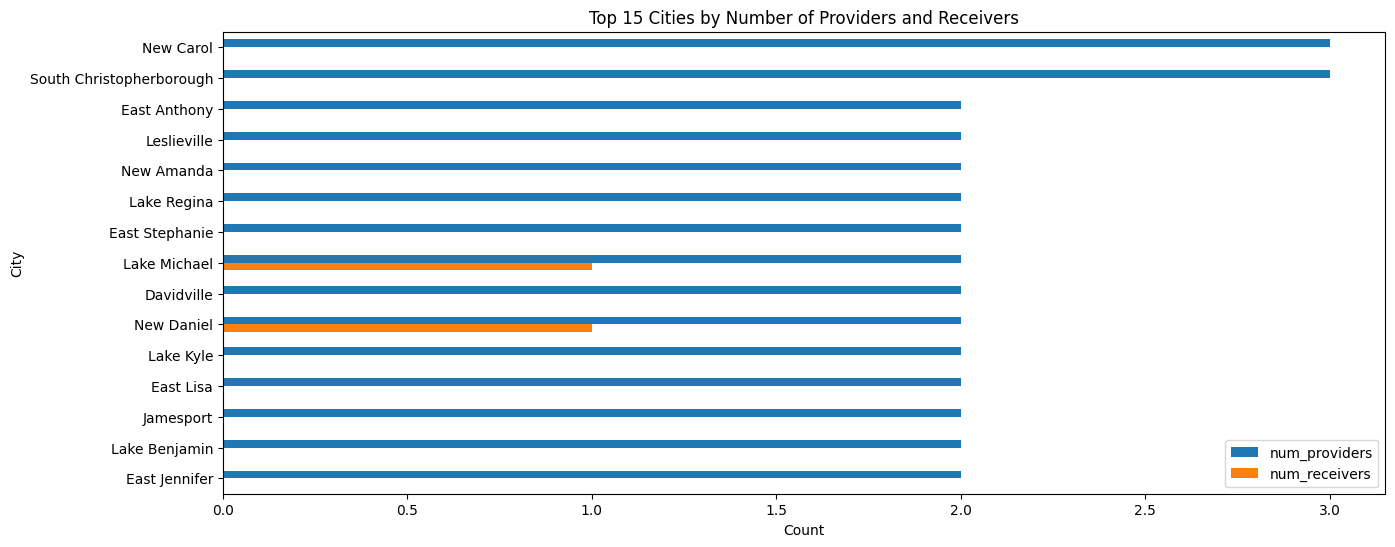

In [30]:
query = """
SELECT p.City AS city,
       COUNT(DISTINCT p.Provider_ID) AS num_providers,
       COUNT(DISTINCT r.Receiver_ID) AS num_receivers
FROM providers p
LEFT JOIN receivers r ON p.City = r.City
GROUP BY p.City
ORDER BY num_providers DESC
LIMIT 15;
"""

cursor.execute(query)
df1 = pd.DataFrame(cursor.fetchall(), columns=[col[0] for col in cursor.description])

df1.set_index("city")[["num_providers", "num_receivers"]].plot(
    kind="barh", figsize=(15,6)
)
plt.title("Top 15 Cities by Number of Providers and Receivers")
plt.xlabel("Count")
plt.ylabel("City")
plt.gca().invert_yaxis()
plt.show()



> Query   : How many food providers and receivers are there in each city?

> Insigth : Based on the chart, nearly every city has 2 or 3 food providers, while only Lake Michael and New Daniel show a single food receiver each—looks like providers greatly outnumber receivers everywhere

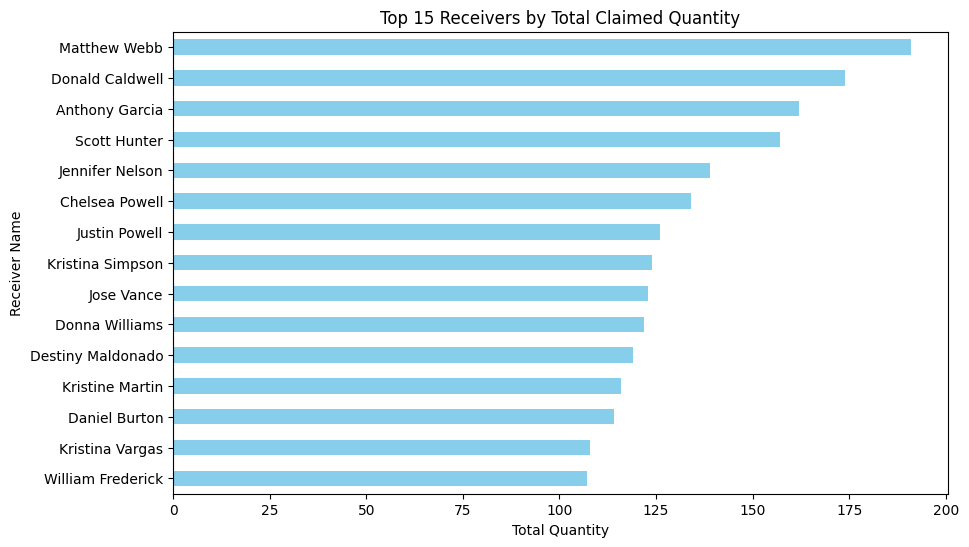

In [29]:
query = """
SELECT r.Name AS receiver_name,
       SUM(f.Quantity) AS total_quantity
FROM claims c
JOIN receivers r ON c.Receiver_ID = r.Receiver_ID
JOIN food_listings f ON c.Food_ID = f.Food_ID
GROUP BY r.Receiver_ID, r.Name
ORDER BY total_quantity DESC
LIMIT 15;
"""

cursor.execute(query)
df2 = pd.DataFrame(cursor.fetchall(), columns=[col[0] for col in cursor.description])

df2["total_quantity"] = pd.to_numeric(df2["total_quantity"], errors="coerce")

df2.set_index("receiver_name")["total_quantity"].plot(
    kind="barh", figsize=(10,6), color="skyblue"
)
plt.title("Top 15 Receivers by Total Claimed Quantity")
plt.xlabel("Total Quantity")
plt.ylabel("Receiver Name")
plt.gca().invert_yaxis()
plt.show()


> Query   : Which receivers have claimed the most food?

> Insigth : Looks like Matthew Webb snagged the most food by far, with Donald Caldwell and Anthony Garcia not too far behind—those three are definitely topping the list of hungry receivers

In [28]:
query = """
SELECT p.Address, p.Contact
FROM providers p
WHERE p.City = 'New Jessica';
"""

cursor.execute(query)
df3 = pd.DataFrame(cursor.fetchall(), columns=[col[0] for col in cursor.description])

print("Contact Information for Providers in New York:")
print(df3)


Contact Information for Providers in New York:
                                             Address          Contact
0  74347 Christopher Extensions\nAndreamouth, OK ...  +1-600-220-0480


> Query   : What is the contact information of food providers in a specific city?

> Insigth : Here i checked only for New Jessica, seems like there is only 1 provider but there might be many in other cities.

In [16]:
cursor.execute("SHOW COLUMNS FROM claims;")
print(cursor.fetchall())


[('Claim_ID', 'bigint', 'YES', '', None, ''), ('Food_ID', 'bigint', 'YES', '', None, ''), ('Receiver_ID', 'bigint', 'YES', '', None, ''), ('Status', 'text', 'YES', '', None, ''), ('Timestamp', 'text', 'YES', '', None, '')]


In [20]:
query = """
SELECT SUM(Quantity) AS total_quantity
FROM food_listings;
"""
cursor.execute(query)

result = cursor.fetchone()
total_quantity = result[0] if result else 0

print(f"Total quantity of food available from all providers: {total_quantity}")



Total quantity of food available from all providers: 25794


> Query   : What is the total quantity of food available from all providers?

> Insigth : The Total quantity of food available from all providers: 25794

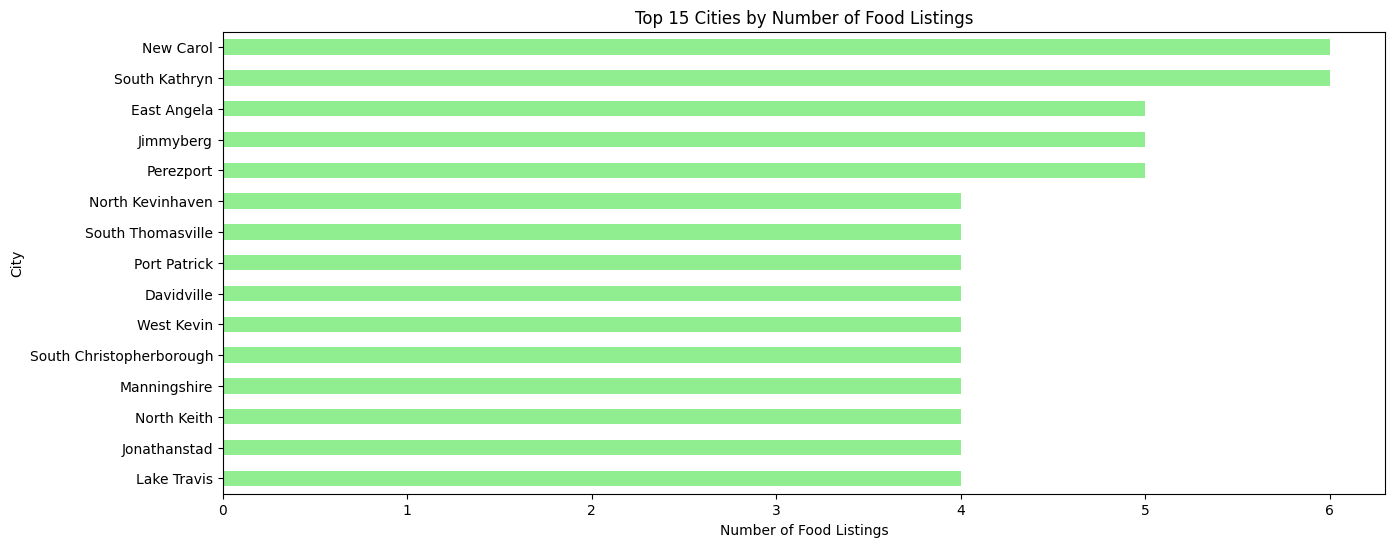

In [21]:
query = """
SELECT Location AS city, COUNT(Food_ID) AS num_food_listings
FROM food_listings
GROUP BY Location
ORDER BY num_food_listings DESC
LIMIT 15;
"""
cursor.execute(query)
df = pd.DataFrame(cursor.fetchall(), columns=[col[0] for col in cursor.description])

df.set_index("city")["num_food_listings"].plot(
    kind="barh", figsize=(15,6), color='lightgreen'
)
plt.title("Top 15 Cities by Number of Food Listings")
plt.xlabel("Number of Food Listings")
plt.ylabel("City")
plt.gca().invert_yaxis()
plt.show()


> Query   : Which city has the highest number of food listings?

> Insigth : New Carol totally leads the pack with the highest number of food listings—it’s clearly the hotspot for food options among all the cities

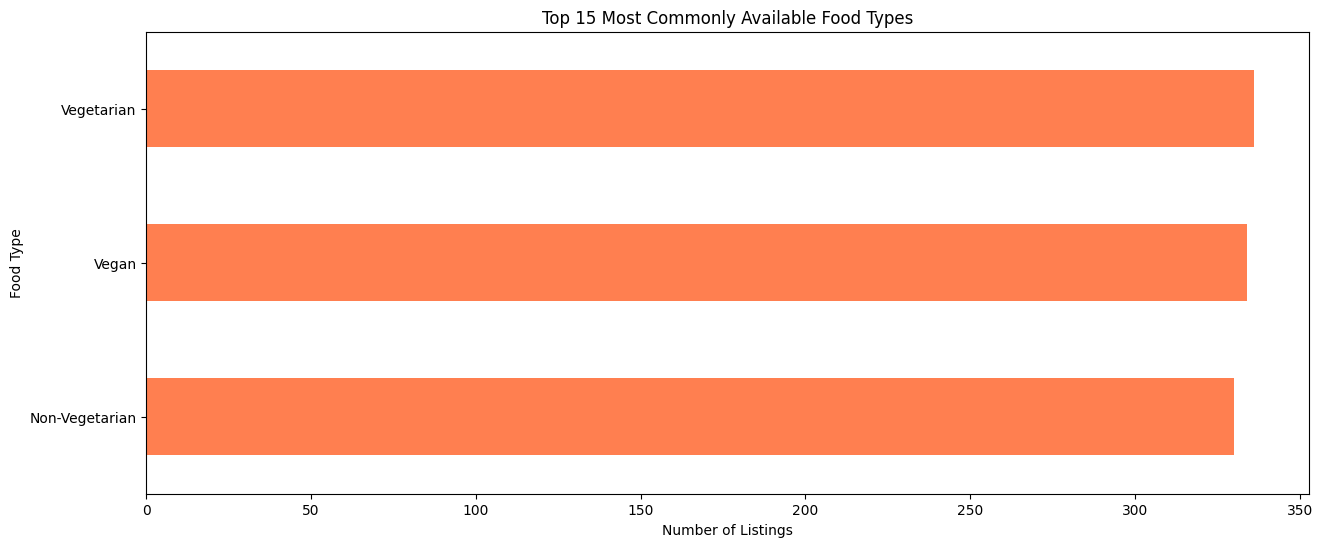

In [22]:
query = """
SELECT Food_Type, COUNT(Food_ID) AS count_food_type
FROM food_listings
GROUP BY Food_Type
ORDER BY count_food_type DESC
LIMIT 15;
"""
cursor.execute(query)
df = pd.DataFrame(cursor.fetchall(), columns=[col[0] for col in cursor.description])

df.set_index("Food_Type")["count_food_type"].plot(
    kind="barh", figsize=(15,6), color='coral'
)
plt.title("Top 15 Most Commonly Available Food Types")
plt.xlabel("Number of Listings")
plt.ylabel("Food Type")
plt.gca().invert_yaxis()
plt.show()


> Query   : What are the most commonly available food types?

> Insigth : Judging by the chart, veggie options (vegetarian and vegan) seem just as popular as non-veg—so you’ll find plenty of choices no matter your preference

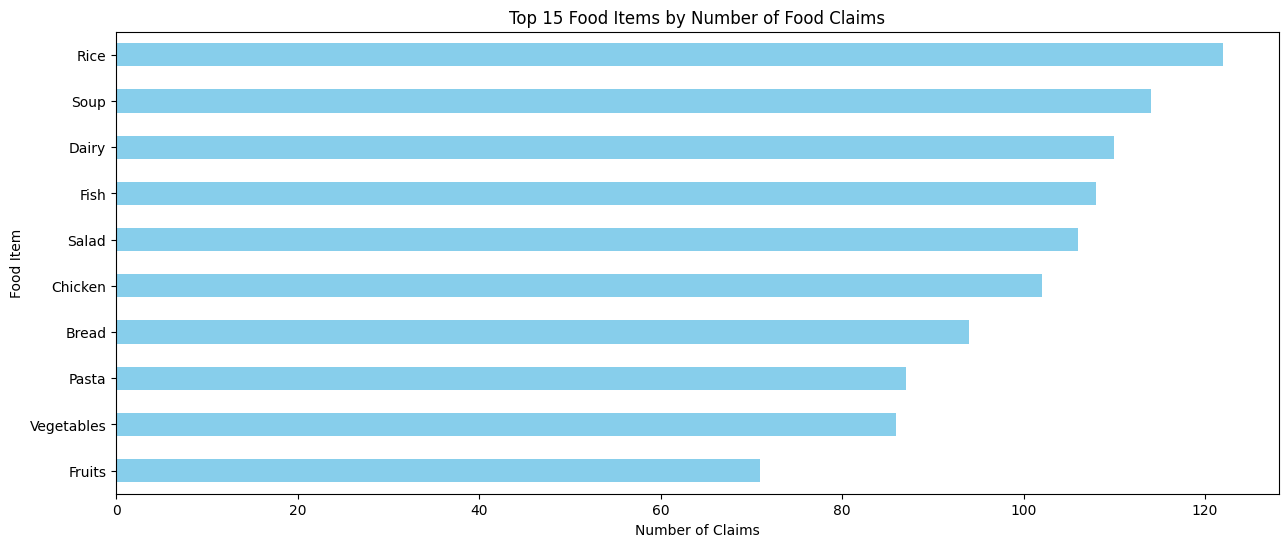

In [23]:
query = """
SELECT fl.Food_Name, COUNT(c.Claim_ID) AS total_claims
FROM food_listings fl
JOIN claims c ON fl.Food_ID = c.Food_ID
GROUP BY fl.Food_Name
ORDER BY total_claims DESC
LIMIT 15;
"""
cursor.execute(query)
df = pd.DataFrame(cursor.fetchall(), columns=[col[0] for col in cursor.description])

df.set_index("Food_Name")["total_claims"].plot(
    kind="barh", figsize=(15,6), color='skyblue'
)
plt.title("Top 15 Food Items by Number of Food Claims")
plt.xlabel("Number of Claims")
plt.ylabel("Food Item")
plt.gca().invert_yaxis()
plt.show()


> Query   : How many food claims have been made for each food item?

> Insigth : According to the chart, rice is the absolute favorite with the highest number of food claims—looks like everyone’s reaching for a bowl of carbs

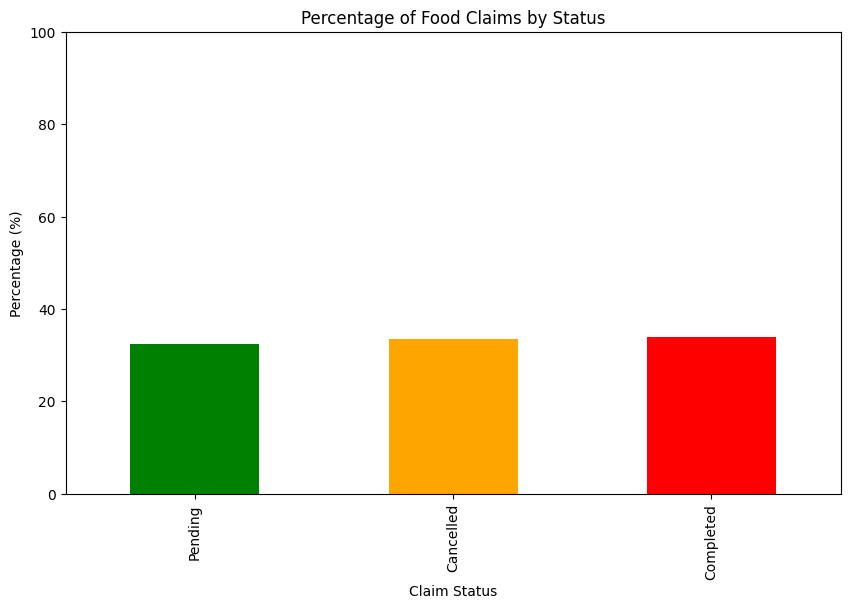

      Status  count_status  percentage
0    Pending           325        32.5
1  Cancelled           336        33.6
2  Completed           339        33.9


In [31]:
query = """
SELECT Status, COUNT(*) AS count_status
FROM claims
GROUP BY Status;
"""
cursor.execute(query)
df = pd.DataFrame(cursor.fetchall(), columns=[col[0] for col in cursor.description])

total_claims = df['count_status'].sum()
df['percentage'] = (df['count_status'] / total_claims) * 100

df.set_index('Status')['percentage'].plot(
    kind='bar', figsize=(10,6), color=['green', 'orange', 'red']
)
plt.title('Percentage of Food Claims by Status')
plt.ylabel('Percentage (%)')
plt.xlabel('Claim Status')
plt.ylim(0, 100)
plt.show()

print(df)


> Query   : What percentage of food claims are completed vs. pending vs. canceled?

> Insigth : From the chart, it looks like food claims are split almost evenly across completed, pending, and canceled—no single status really dominates the scene

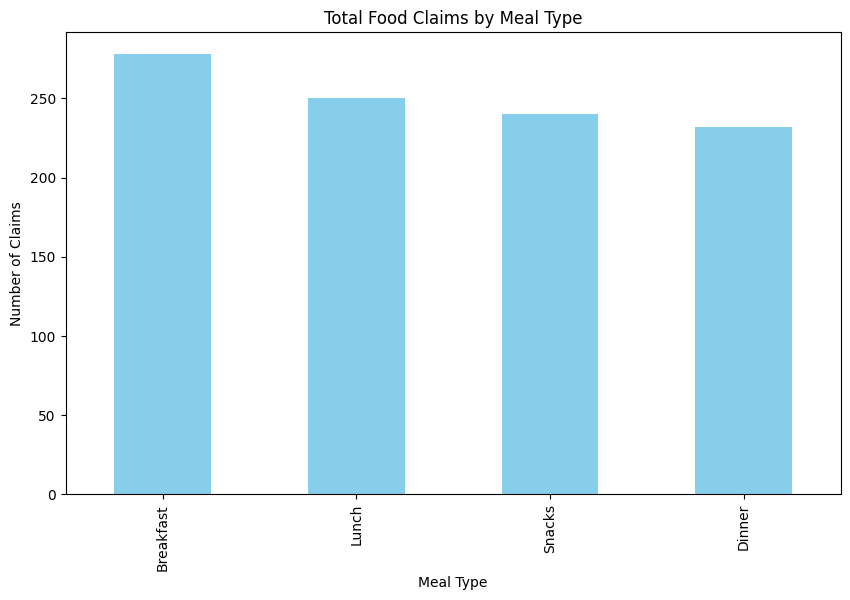

In [33]:
query = """
SELECT fl.Meal_Type, COUNT(c.Claim_ID) AS total_claims
FROM claims c
JOIN food_listings fl ON c.Food_ID = fl.Food_ID
GROUP BY fl.Meal_Type
ORDER BY total_claims DESC;
"""
cursor.execute(query)
df = pd.DataFrame(cursor.fetchall(), columns=[col[0] for col in cursor.description])

df.set_index("Meal_Type")["total_claims"].plot(
    kind="bar", figsize=(10,6), color="skyblue"
)
plt.title("Total Food Claims by Meal Type")
plt.xlabel("Meal Type")
plt.ylabel("Number of Claims")
plt.show()


> Query   : Which meal type (breakfast, lunch, dinner, snacks) is claimed the most?

> Insigth : Looks like breakfast is the runaway winner here—people are claiming breakfast meals more than any other type, so early birds are definitely eating well